# Almond Classification Model

# Imports

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from scipy.stats import chi2_contingency, f_oneway, anderson
import scipy.stats as stats


from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif
from sklearn.preprocessing import PowerTransformer, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline as sklearnPipeline
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, confusion_matrix

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE

# Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier

# Functions

In [45]:
def check_for_nulls_dupes(df):
  print(f"The amount of Null Values: {df.isna().sum()}")
  print(f"The amount of Duplicated Values {df.duplicated().sum()}")

def check_class_imbalance(target):
  unique, counts = np.unique(target, return_counts=True)
  
  plt.figure(figsize=(10, 7))
  plt.pie(counts, labels=unique, startangle=140, autopct="%1.1f%%")
  plt.title("Target Class Breakdown")
  plt.legend()
  plt.show()
  
  plt.figure(figsize=(10, 7))
  sns.countplot(x=target)
  plt.xlabel("Target Class Breakdown")
  plt.ylabel("Counts")
  plt.show()

def plot_distribution(df, kind):
  
  plt.figure(figsize=(16,16))
  columns = len(df.columns)
  rows = (columns + 3) //4
  
  for idx, col in enumerate(df.columns):
    if col == "Type":
      continue
    plt.subplot(rows ,4, idx+1)
    sns.histplot(df[col], kde=True) if kind == "hist" else plt.boxplot(df[col])
    plt.title(f"Distribuition of {col}")
    plt.ylabel("Counts")

  plt.tight_layout()
  plt.show()

def dist_plot(df, col):
  salary_skewness = df[col].skew()
  salary_kurtosis = df[col].kurtosis()

  plt.figure(figsize=(10, 6))
  sns.histplot(df[col], kde=True, color='blue')
  plt.title(f'Distribution of {col} with Skewness and Kurtosis')
  plt.xlabel(col)
  plt.ylabel('Frequency')

  plt.text(x=0.95, y=0.85, s=f"Skewness: {salary_skewness:.2f}", transform=plt.gca().transAxes, horizontalalignment='right')
  plt.text(x=0.95, y=0.80, s=f"Kurtosis: {salary_kurtosis:.2f}", transform=plt.gca().transAxes, horizontalalignment='right')

  plt.grid(True)
  plt.show()
  
def aggregate_dataset(df, interested_columns, agg_col, function):
  
  plt.figure(figsize=(12,12))
  columns = len(df.columns)
  rows = (columns + 3) //4
  
  for idx, col in enumerate(interested_columns):
    if col == agg_col:
      continue
    plt.subplot(rows ,4, idx+1)
    grouped_df = getattr(df.groupby(agg_col)[col], function)().reset_index(name=col)
    sns.barplot(data=grouped_df, x=agg_col, y=col)
    plt.title(f"Agg of {col}")
    plt.ylabel(col)
    plt.xticks(rotation =45)
  plt.tight_layout()
  plt.show()

def scatter_plot(df, interested_columns, target):
  
  plt.figure(figsize=(12,10))
  columns = len(df.columns)
  rows = (columns + 3) //4
  
  for idx, col in enumerate(interested_columns):
    if col == target:
      continue
    plt.subplot(rows ,3, idx+1)
    sns.scatterplot(data=df, x=target, y=col, hue=col)
  plt.tight_layout()
  plt.show()

def chi_value_tests(df, interested_columns, target):
  
  for col in interested_columns:
    print(f"Column Is: {col}")
    contingency_table = pd.crosstab(df[target], df[col])
    chi2, p_val, _, _ = chi2_contingency(contingency_table)
    print(f"Chi-Square Test:\nChi2 Statistic: {chi2}, P-value: {p_val}")

def create_column_transformer(numeric_cols, mean_cols, median_cols):
  
  mean_transformer = Pipeline(
    steps=[
      ("mean", SimpleImputer(missing_values=np.nan, strategy="mean"))
    ]
  )
  
  median_transformer = Pipeline(
    steps=[
      ("median", SimpleImputer(missing_values=np.nan, strategy="median"))
    ]
  )
  
  numeric_transformer = Pipeline(
    steps =[
      ("scaler", StandardScaler()),
      ("PowerTransformer", PowerTransformer())
    ]
  )
  
  return ColumnTransformer(
    transformers=[
      ("mean transformer", mean_transformer, mean_cols),
      ("median transformer", median_transformer, median_cols),
      ("numeric", numeric_transformer, numeric_cols)
    ]
  )

def create_sklearn_pipeline(preprocessor,model, kbest=None):
  
  steps = [
    ("preprocessor", preprocessor),
    ("model", model)
  ]
  
  if kbest:
    steps.insert(1, ("Feature Selection", kbest))
  
  return sklearnPipeline(steps=steps)

def pca_analysis(X, preprocessor):
  
  features = range(1, X.shape[1]+1)
  metric_tracker = []
  for component in features:
    pca = PCA(n_components=component)
    pipeline = create_sklearn_pipeline(preprocessor, pca)
    X_pca = pipeline.fit_transform(X)
    cumsum = np.sum(pca.explained_variance_ratio_)
    
    metric_tracker.append(
      {
        "Component": component,
        "CumSum": cumsum
      }
    )
  
  performance_df = pd.DataFrame(metric_tracker)
  plt.figure(figsize=(12, 8))
  plt.title("PCA Analysis")
  sns.barplot(data=performance_df, x="Component", y="CumSum")
  plt.xlabel("Components")
  plt.ylabel("CumSum")
  plt.show()
  return performance_df

# EDA Analysis

In [3]:
df = pd.read_csv("/Users/maukanmir/Downloads/Almond.csv")
df

,Unnamed: 0,Length (major axis),Width (minor axis),Thickness (depth),Area,Perimeter,Roundness,Solidity,Compactness,Aspect Ratio,Eccentricity,Extent,Convex hull(convex area),Type
0,0,NaN,227.940628,127.759132,22619.0,643.813269,NaN,0.973384,1.458265,NaN,NaN,0.681193,23237.5,MAMRA
1,1,NaN,234.188126,128.199509,23038.0,680.984841,NaN,0.957304,1.601844,NaN,NaN,0.656353,24065.5,MAMRA
2,2,NaN,229.418610,125.796547,22386.5,646.943212,NaN,0.967270,1.487772,NaN,NaN,0.683620,23144.0,MAMRA
3,3,NaN,232.763153,125.918808,22578.5,661.227483,NaN,0.965512,1.540979,NaN,NaN,0.685360,23385.0,MAMRA
4,4,NaN,230.150742,107.253448,19068.0,624.842706,NaN,0.951450,1.629395,NaN,NaN,0.714800,20041.0,MAMRA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2798,2798,NaN,192.709366,122.356506,18471.5,653.345233,NaN,0.931000,1.838965,NaN,NaN,0.725739,19840.5,SANORA
2799,2799,NaN,186.254745,118.708961,17213.5,581.688379,NaN,0.952706,1.564234,NaN,NaN,0.714016,18068.0,SANORA
2800,2800,NaN,186.196182,119.147224,17510.5,608.315795,NaN,0.948821,1.681705,NaN,NaN,0.718999,18455.0,SANORA
2801,2801,NaN,188.660828,120.634438,17941.0,630.759446,NaN,0.944810,1.764701,NaN,NaN,0.738191,18989.0,SANORA


In [4]:
df.drop("Unnamed: 0", axis=1, inplace=True)

# Check Class Imbalance

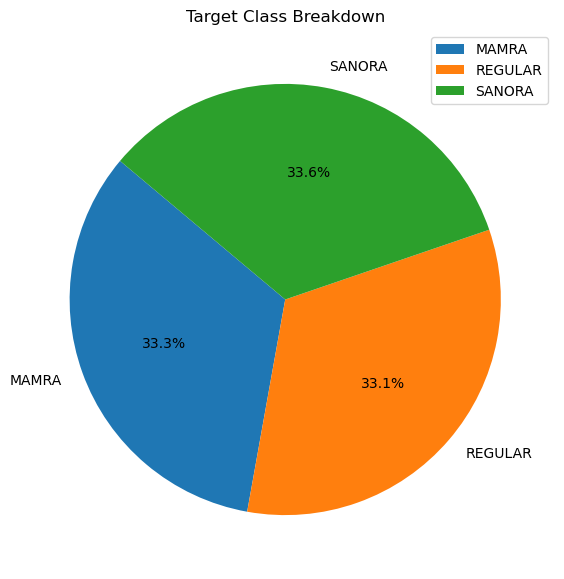

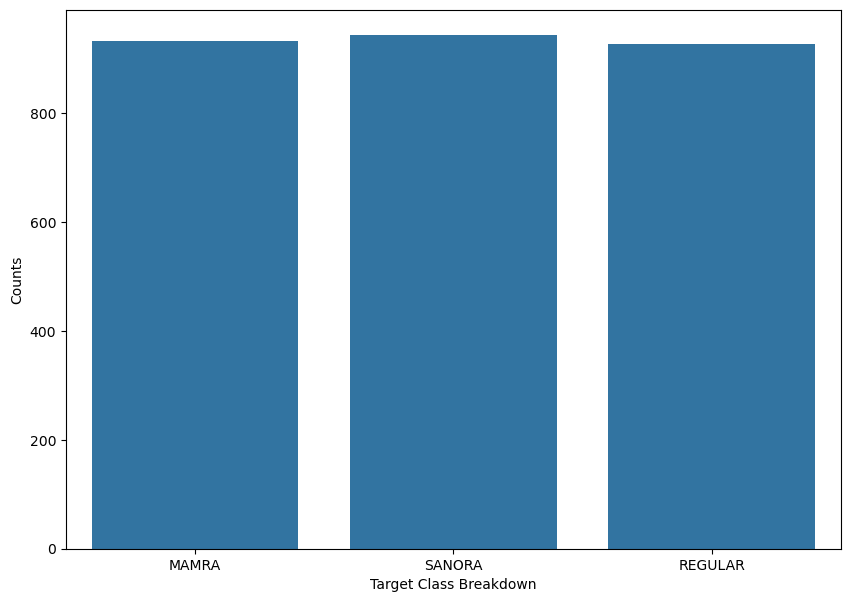

In [5]:
check_class_imbalance(df["Type"])

# Balanced Dataset

In [6]:
check_for_nulls_dupes(df)

The amount of Null Values: Length (major axis)          857
Width (minor axis)           942
Thickness (depth)           1004
Area                           0
Perimeter                      0
Roundness                    857
Solidity                       0
Compactness                    0
Aspect Ratio                1799
Eccentricity                1799
Extent                         0
Convex hull(convex area)       0
Type                           0
dtype: int64
The amount of Duplicated Values 3


In [7]:
df.drop_duplicates(inplace=True)

In [8]:
df.describe()

,Length (major axis),Width (minor axis),Thickness (depth),Area,Perimeter,Roundness,Solidity,Compactness,Aspect Ratio,Eccentricity,Extent,Convex hull(convex area)
count,1944.000000,1859.000000,1797.000000,2800.000000,2800.000000,1944.000000,2800.000000,2800.000000,1003.000000,1003.000000,2800.000000,2800.000000
mean,290.477086,171.037676,109.727607,26503.354107,743.573293,0.470611,0.955919,1.823211,1.752777,0.813038,0.724664,27686.578750
std,62.610007,29.896653,18.938723,13763.416459,230.367902,0.118604,0.039358,0.789515,0.206252,0.041261,0.047410,14215.481045
min,151.335266,88.050529,59.494278,6037.000000,311.563489,0.173748,0.718772,1.164469,1.400082,0.699897,0.454538,6355.000000
25%,245.916424,149.477875,97.267624,16214.000000,571.552339,0.385183,0.944733,1.357361,1.612441,0.784461,0.701889,17093.500000
50%,279.871277,170.168365,110.289268,23421.000000,707.144223,0.473275,0.970482,1.576375,1.705669,0.810108,0.733778,24581.000000
75%,330.273262,190.612556,121.393219,33448.000000,878.825462,0.577628,0.981490,1.963977,1.833105,0.838096,0.757594,34862.875000
max,515.352478,258.569794,181.845200,89282.000000,1864.947387,0.697293,0.992889,9.660057,2.731251,0.930563,0.845813,90642.500000


# We Will have to plug in all of this missing data with either the mean, median or a prediction model. We Will test numerous choices

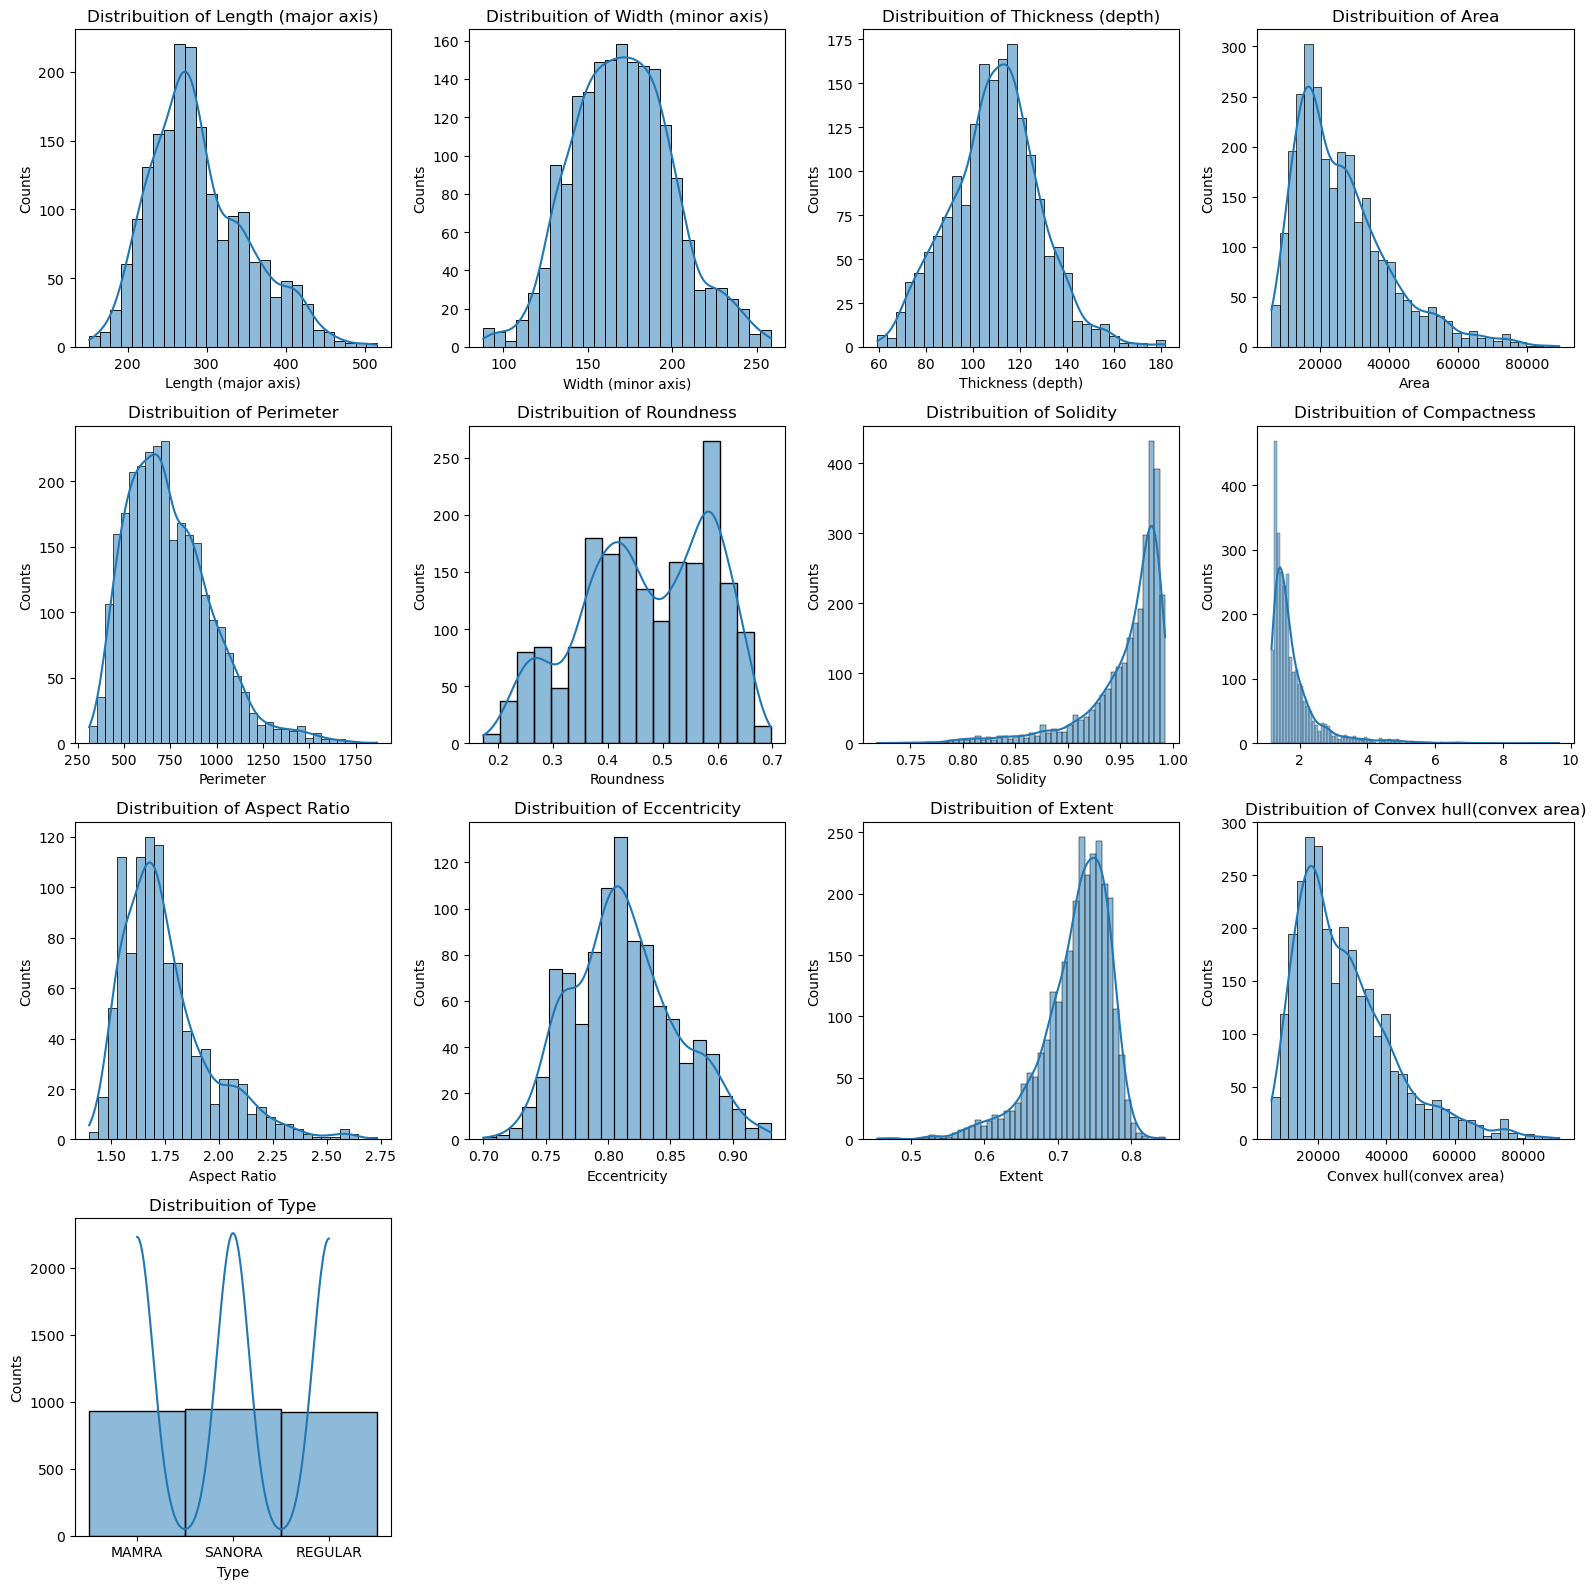

In [9]:
plot_distribution(df, "hist")

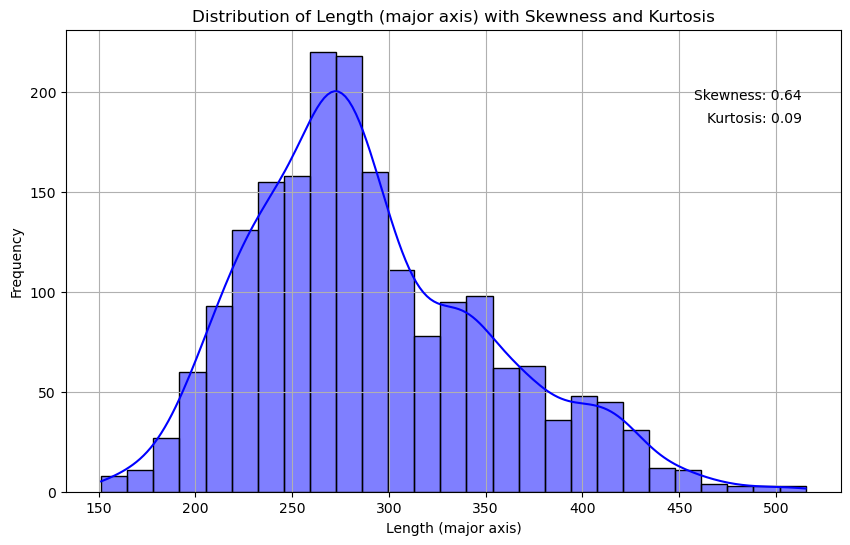

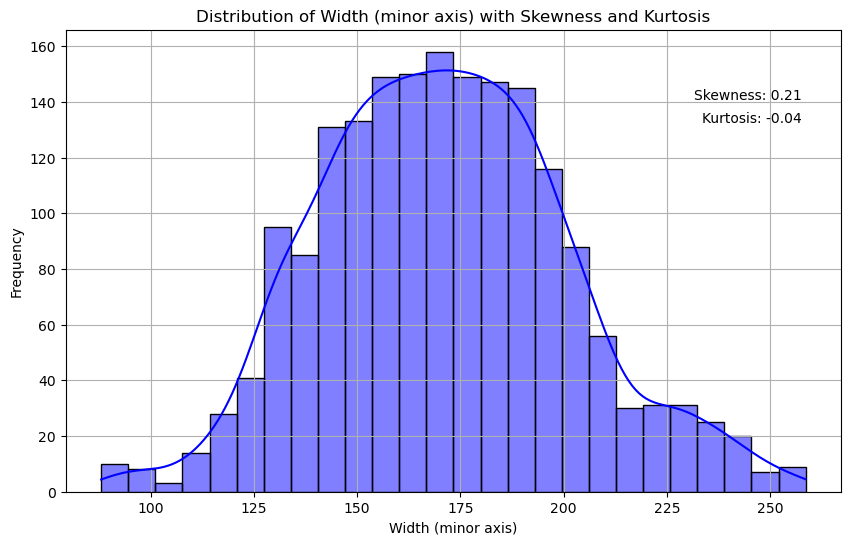

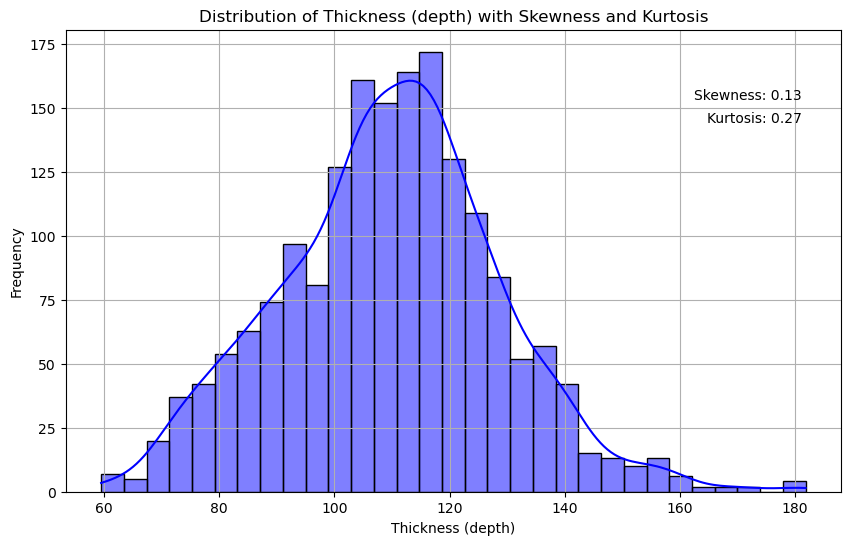

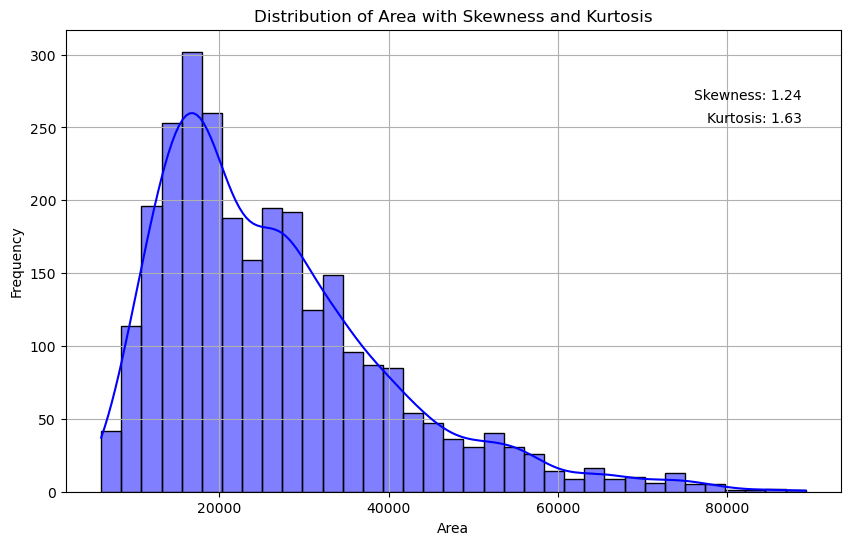

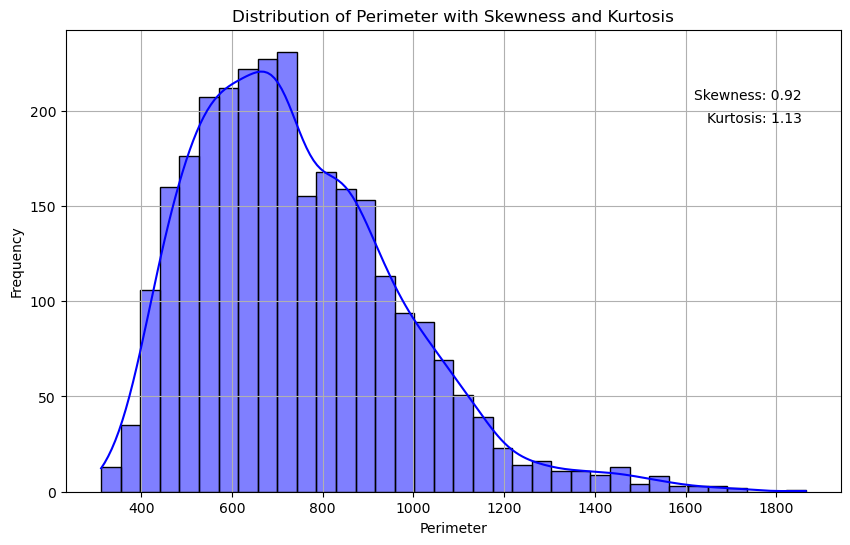

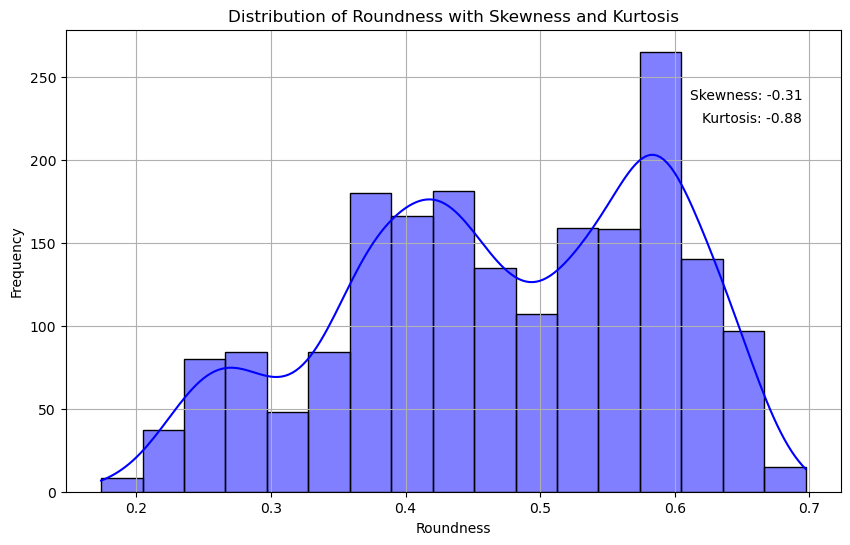

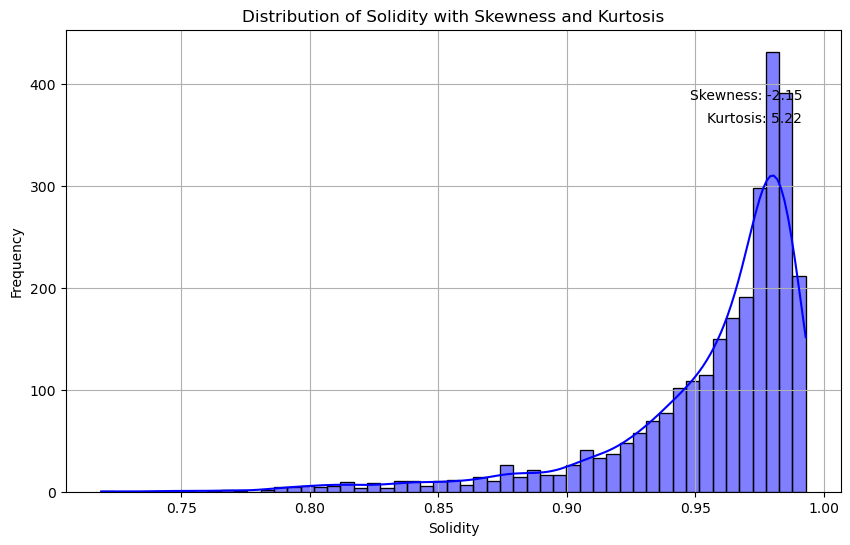

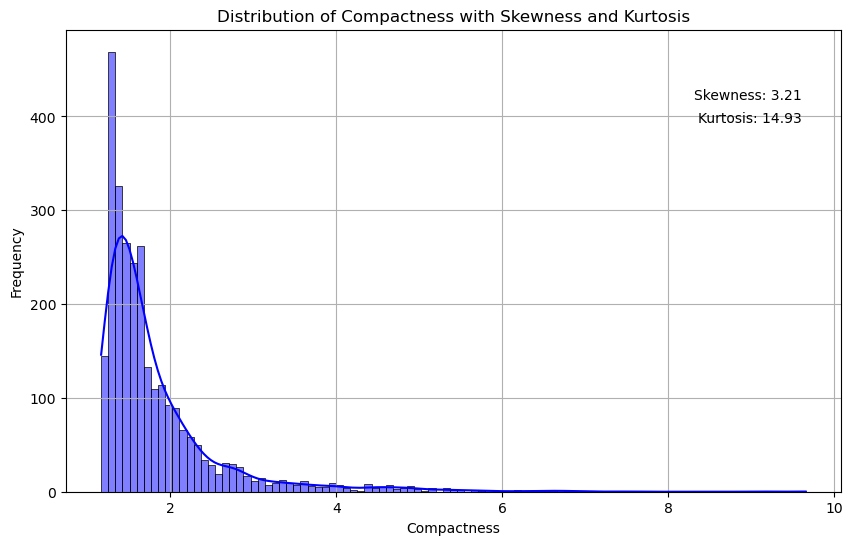

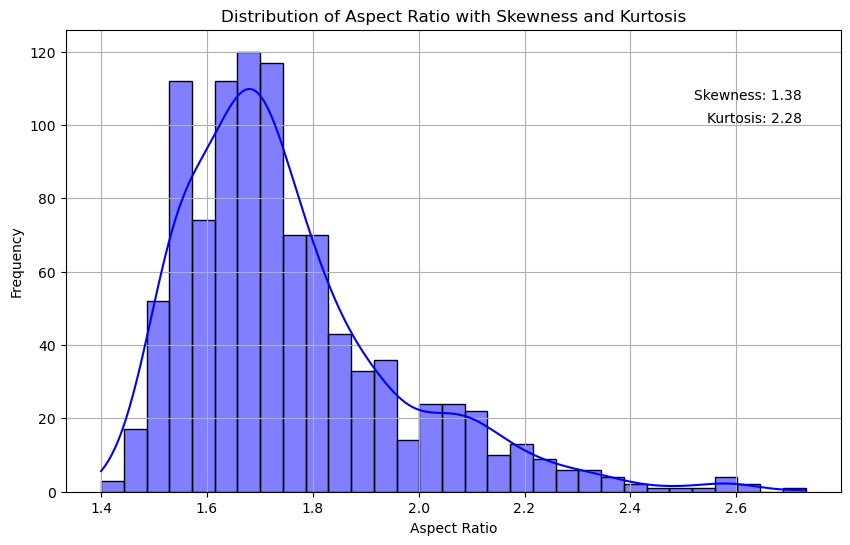

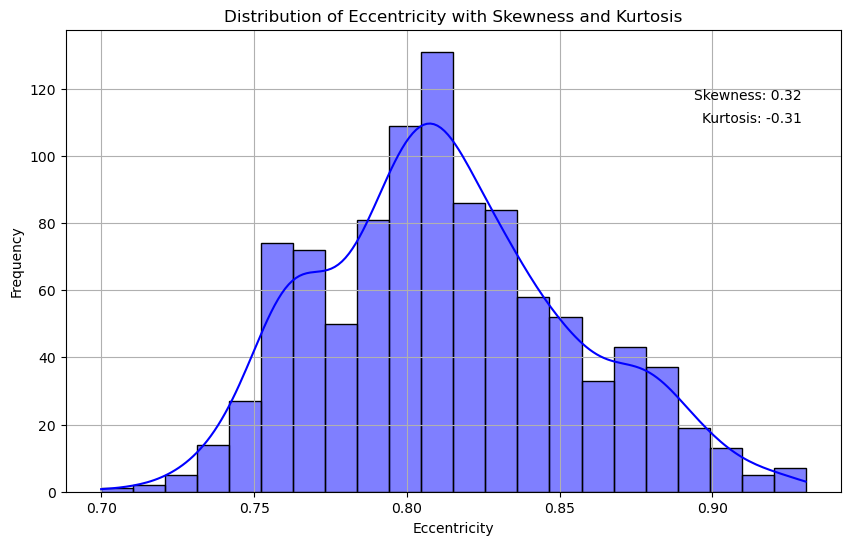

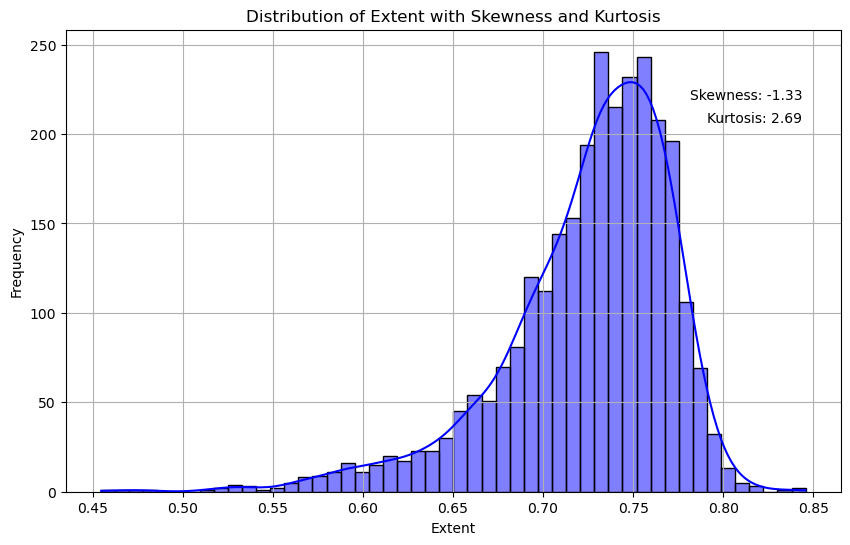

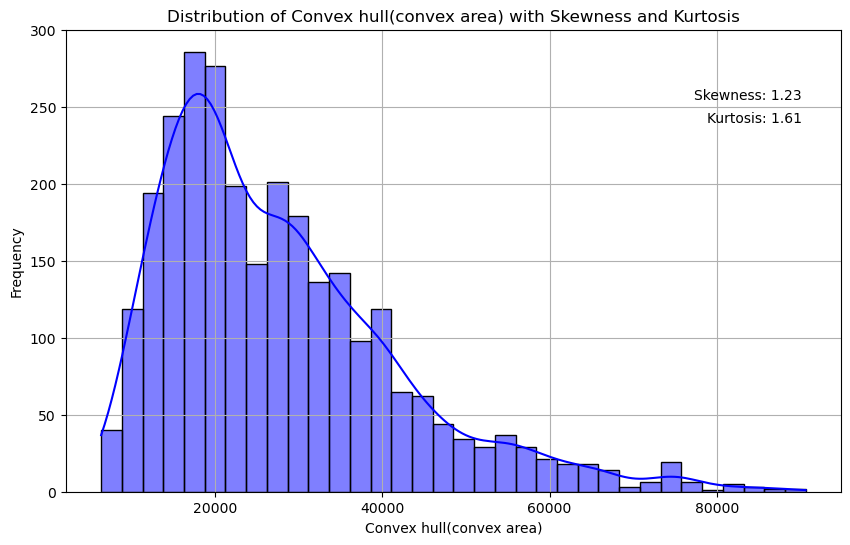

In [10]:
for col in df.columns:
  if col == "Type":
    continue
  dist_plot(df, col)

# If the skewness is between 0.5 and -0.5 then mean if it greater than 0.5 to -0.5 than median

In [11]:
# Length (major axis)          857 = median
# Width (minor axis)           942 = mean
# Thickness (depth)           1004 = mean
# Roundness                    857 = median
# Aspect Ratio                1799 = median
# Eccentricity                1799 = mean

In [12]:
mean_values = [
  "Width (minor axis)",
  "Thickness (depth)",
  'Eccentricity'
  ]

median_values = [
  "Length (major axis)",
  "Roundness",
  'Aspect Ratio'
]

# Processoed DF

In [13]:
process_df = df.copy()

for mean_col, median_col in zip(mean_values, median_values):
  process_df[mean_col] = process_df[mean_col].fillna(process_df[mean_col].median())
  process_df[median_col] = process_df[median_col].fillna(process_df[median_col].median())


In [14]:
process_df.isna().sum()

Length (major axis)         0
Width (minor axis)          0
Thickness (depth)           0
Area                        0
Perimeter                   0
Roundness                   0
Solidity                    0
Compactness                 0
Aspect Ratio                0
Eccentricity                0
Extent                      0
Convex hull(convex area)    0
Type                        0
dtype: int64

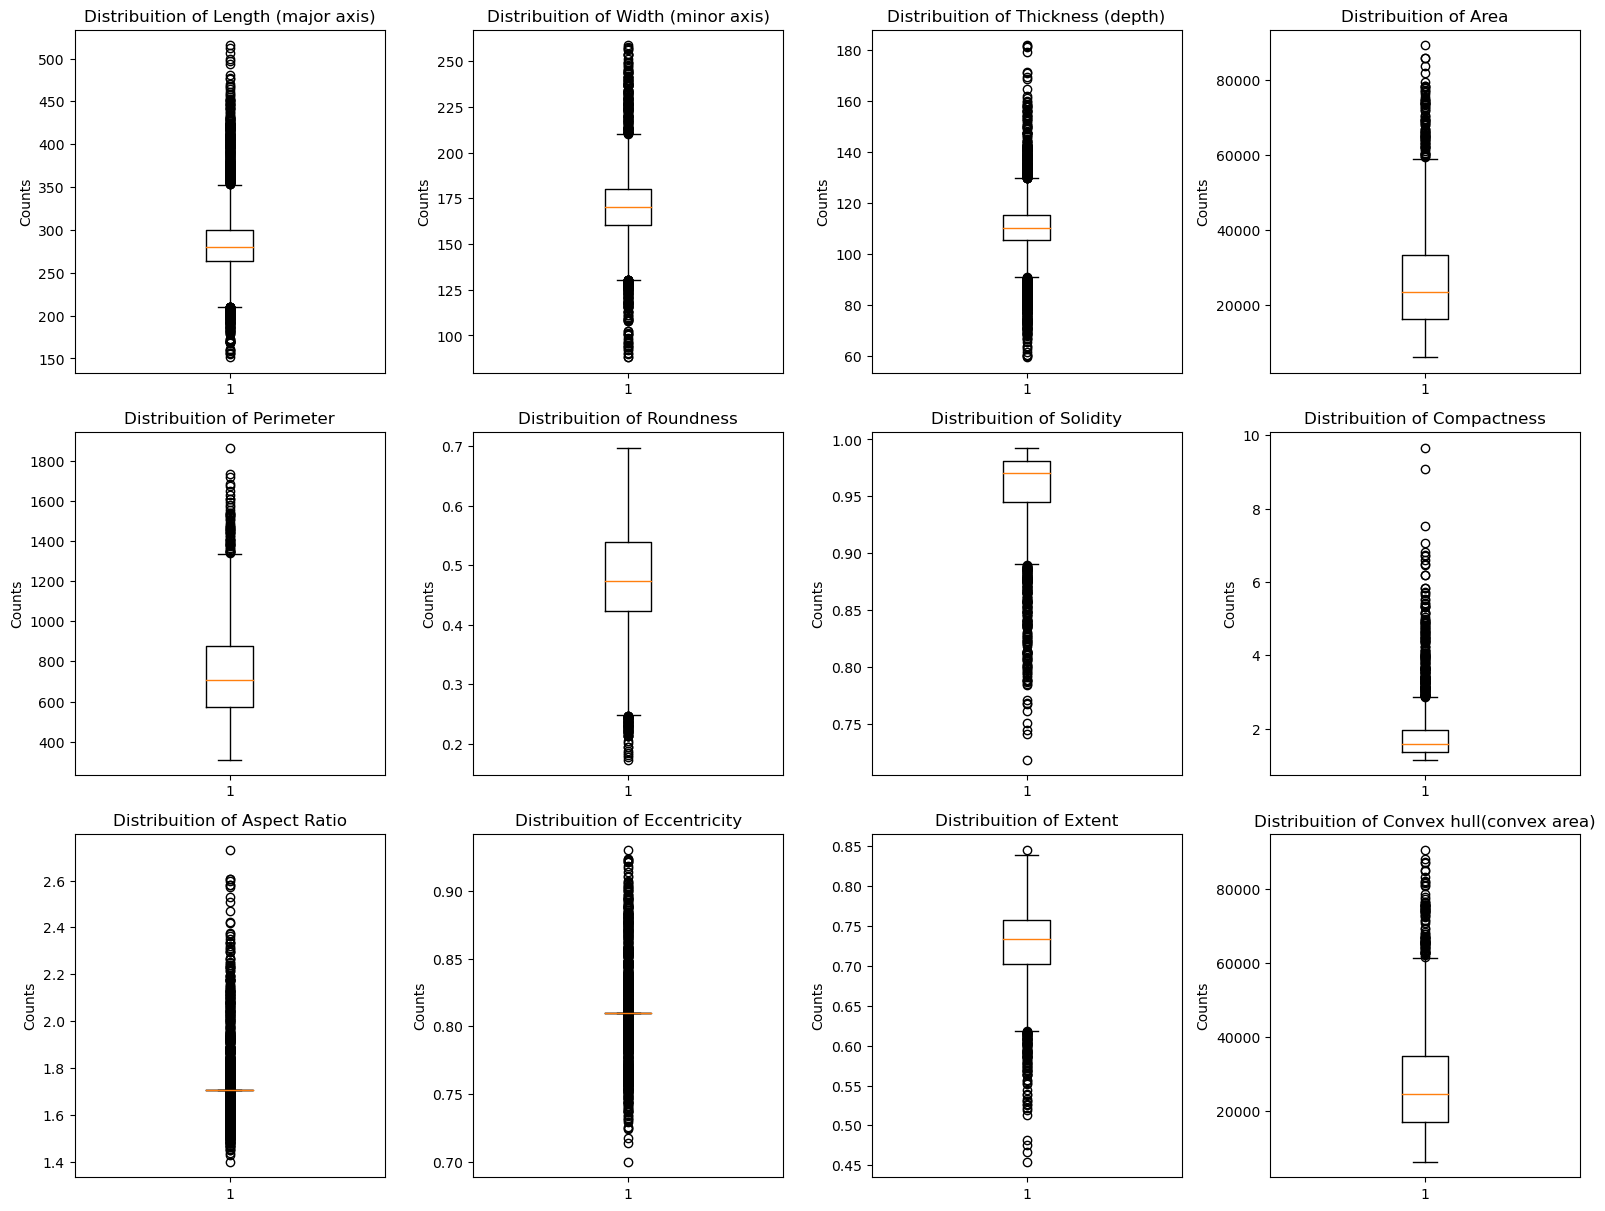

In [19]:
plot_distribution(process_df, 'box')

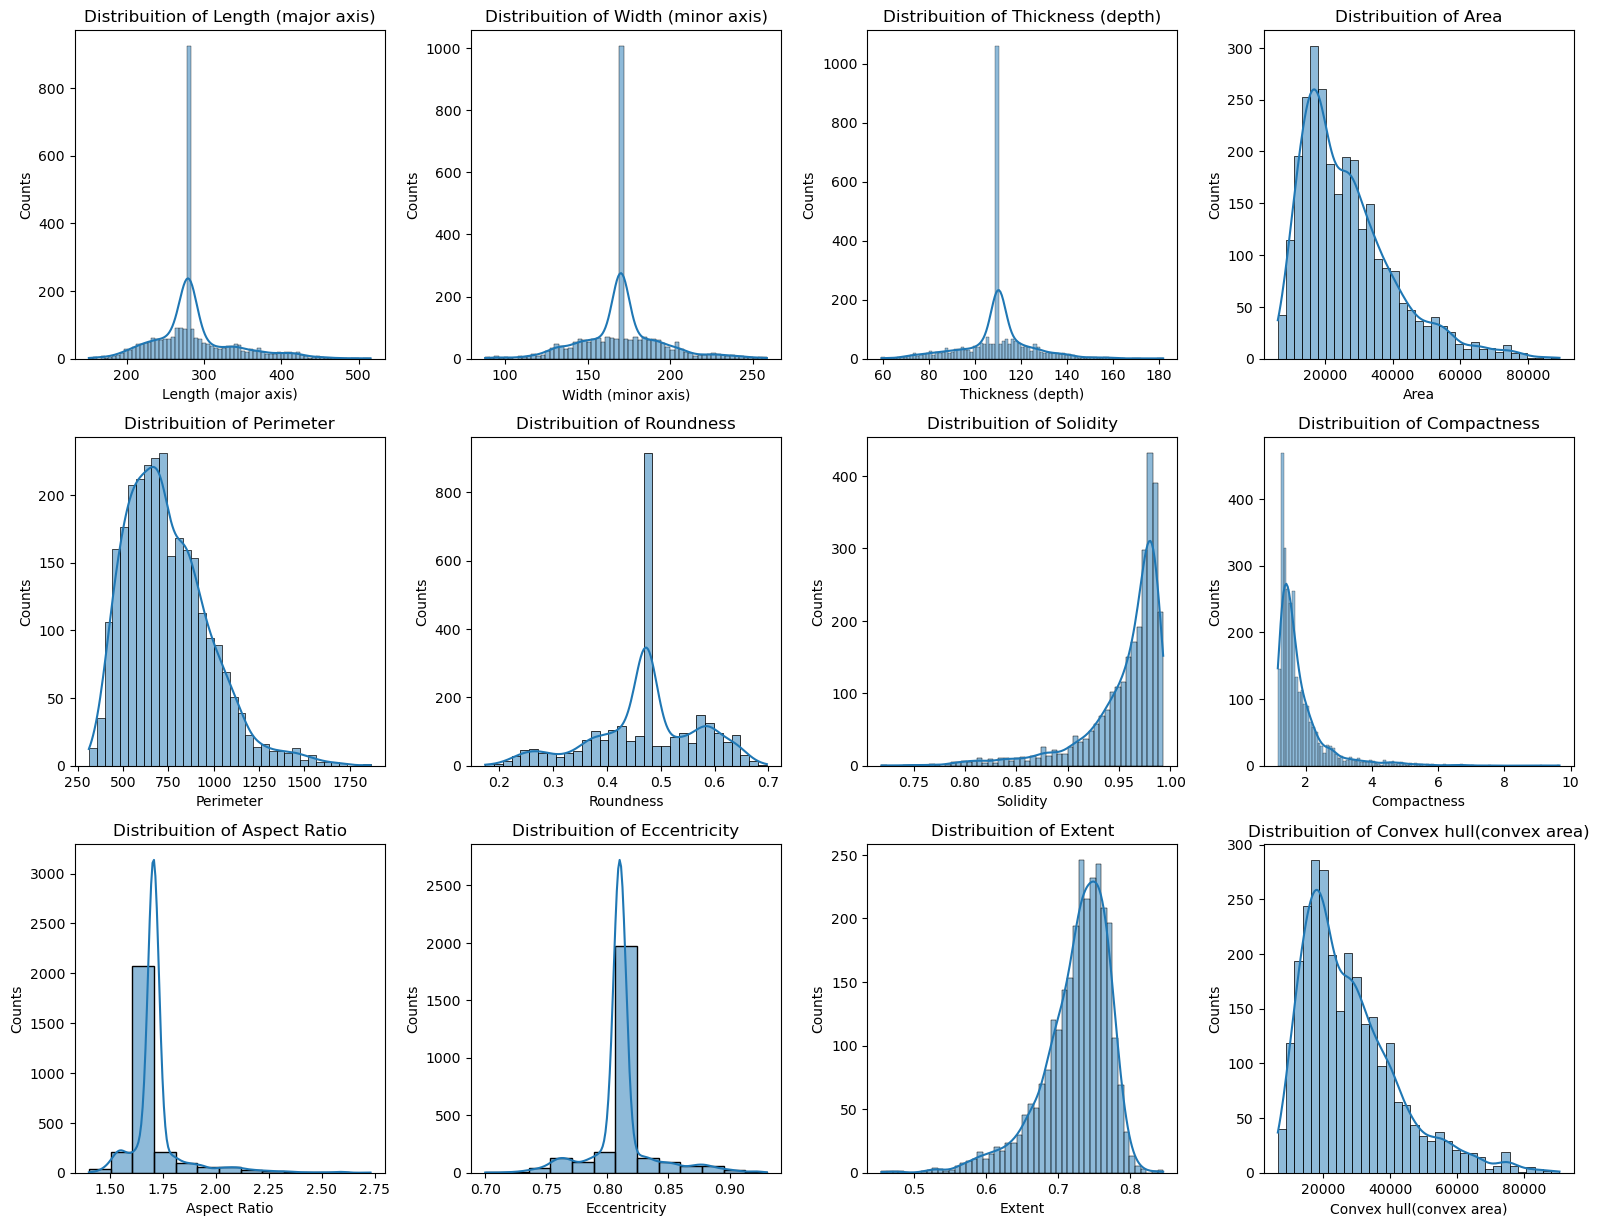

In [20]:
plot_distribution(process_df, 'hist')

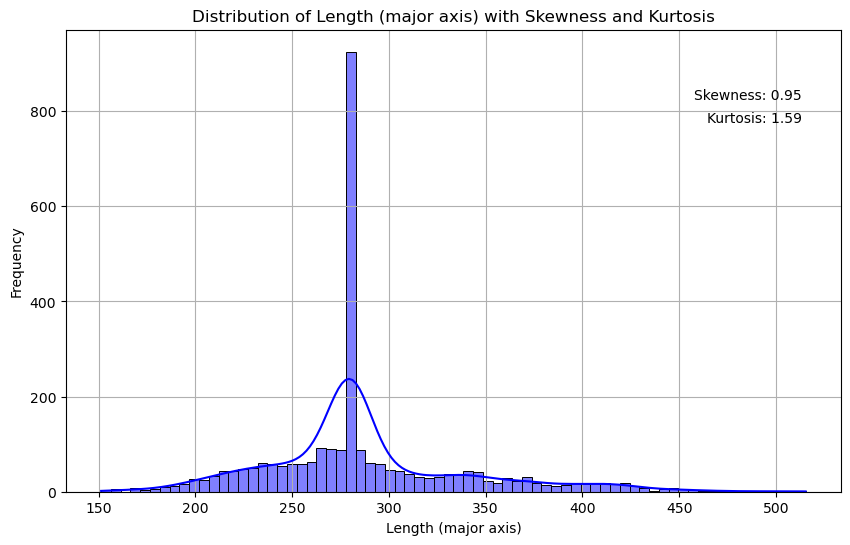

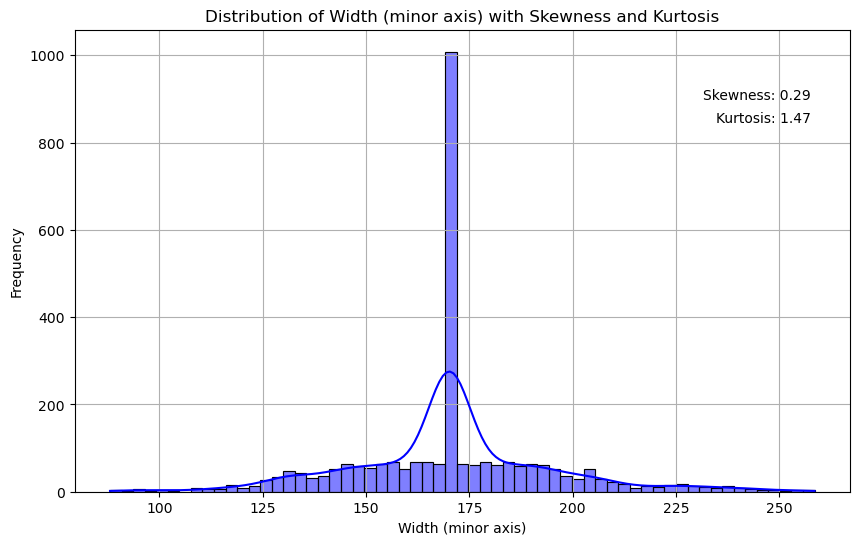

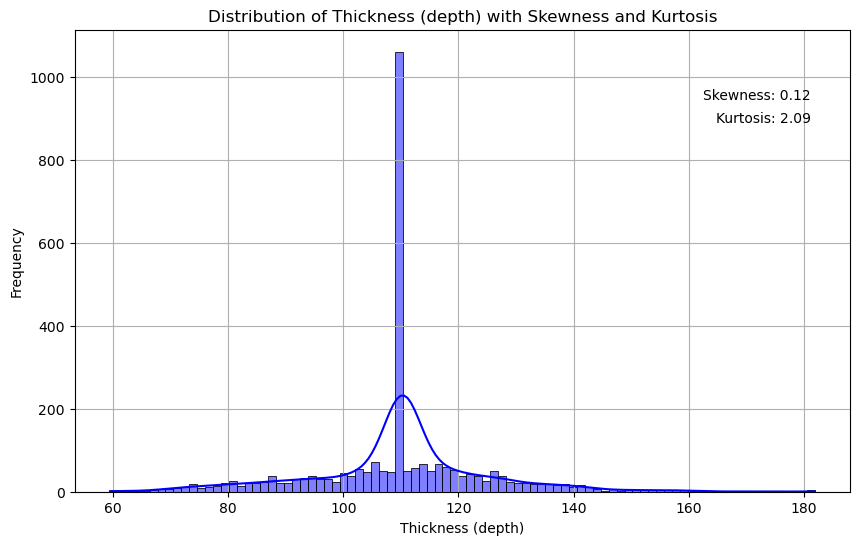

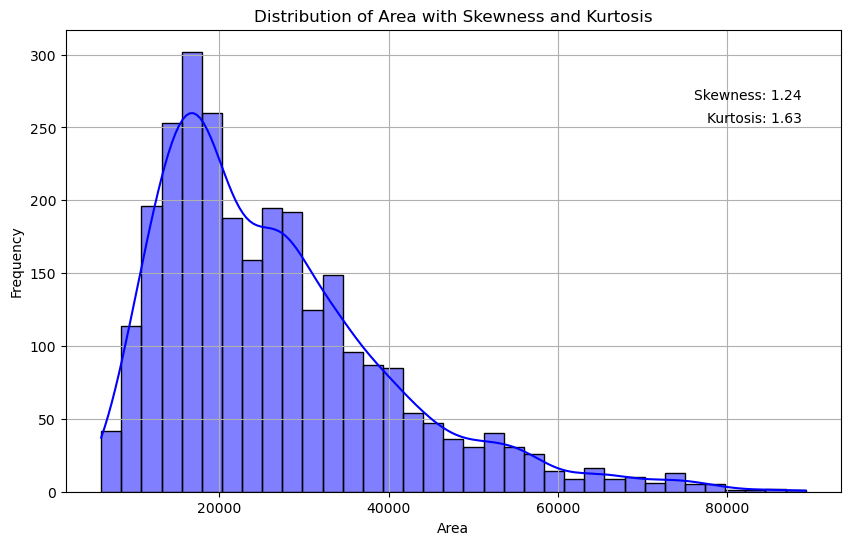

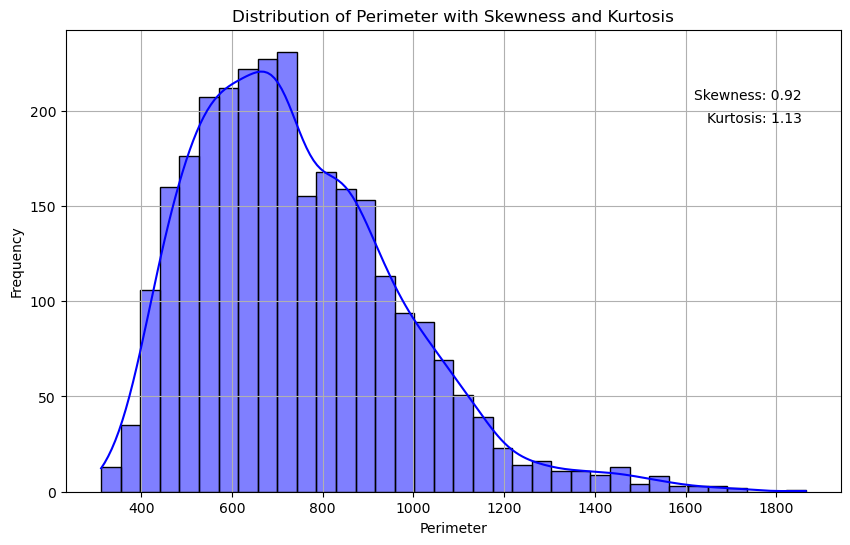

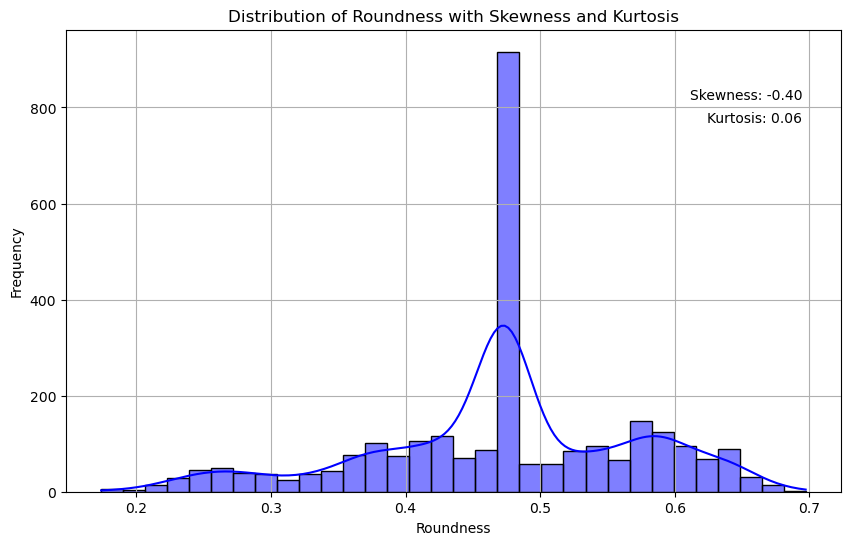

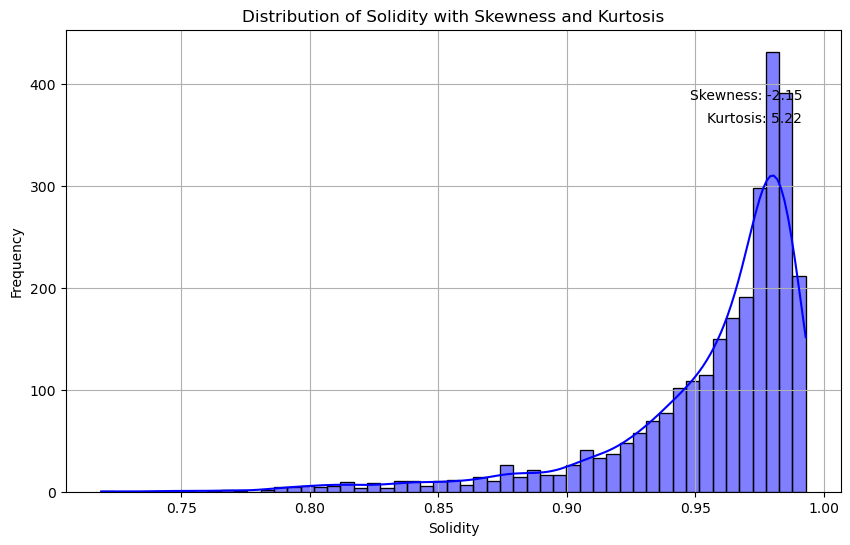

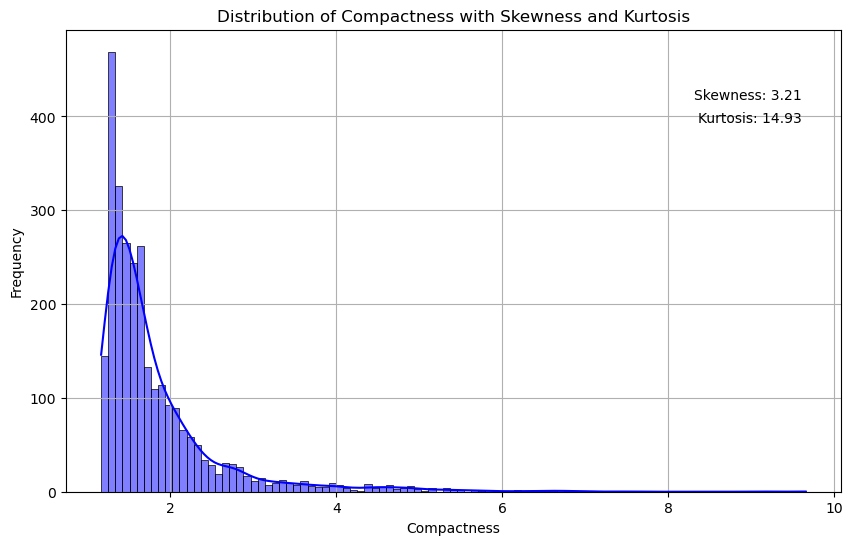

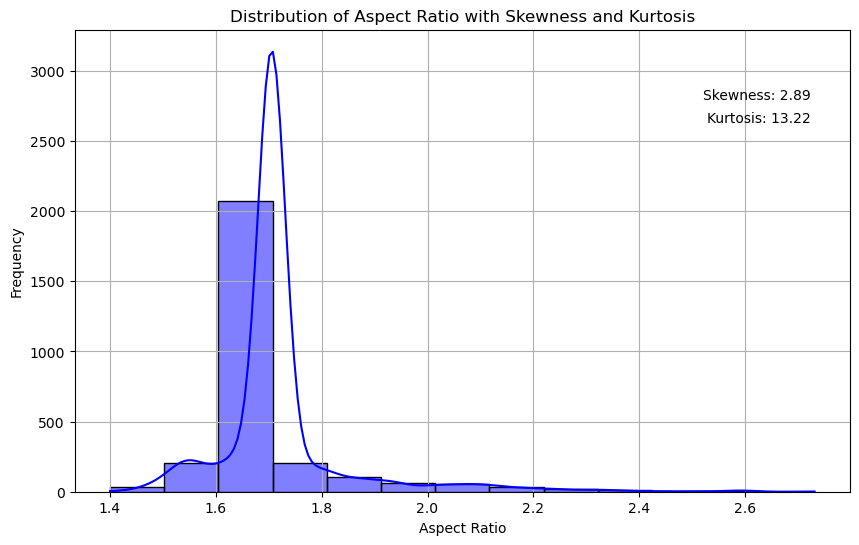

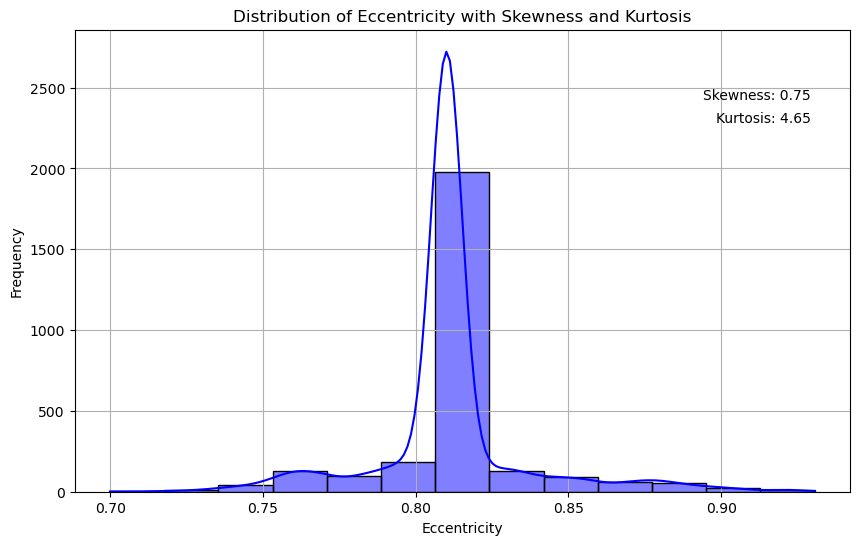

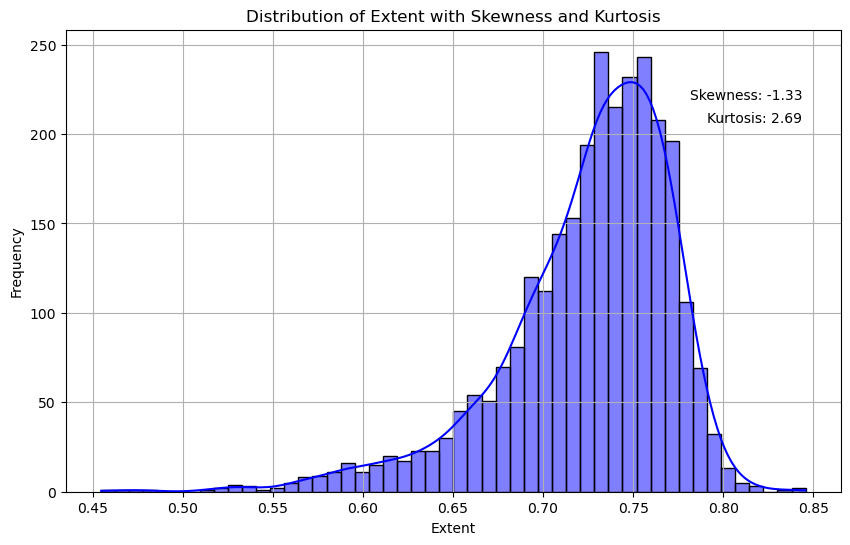

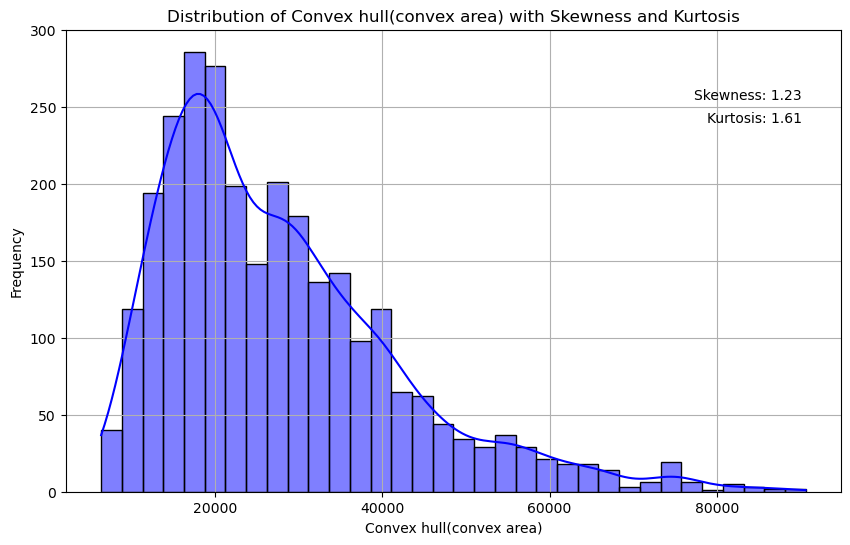

In [22]:
for col in df.columns:
  if col == "Type":
    continue
  dist_plot(process_df, col)

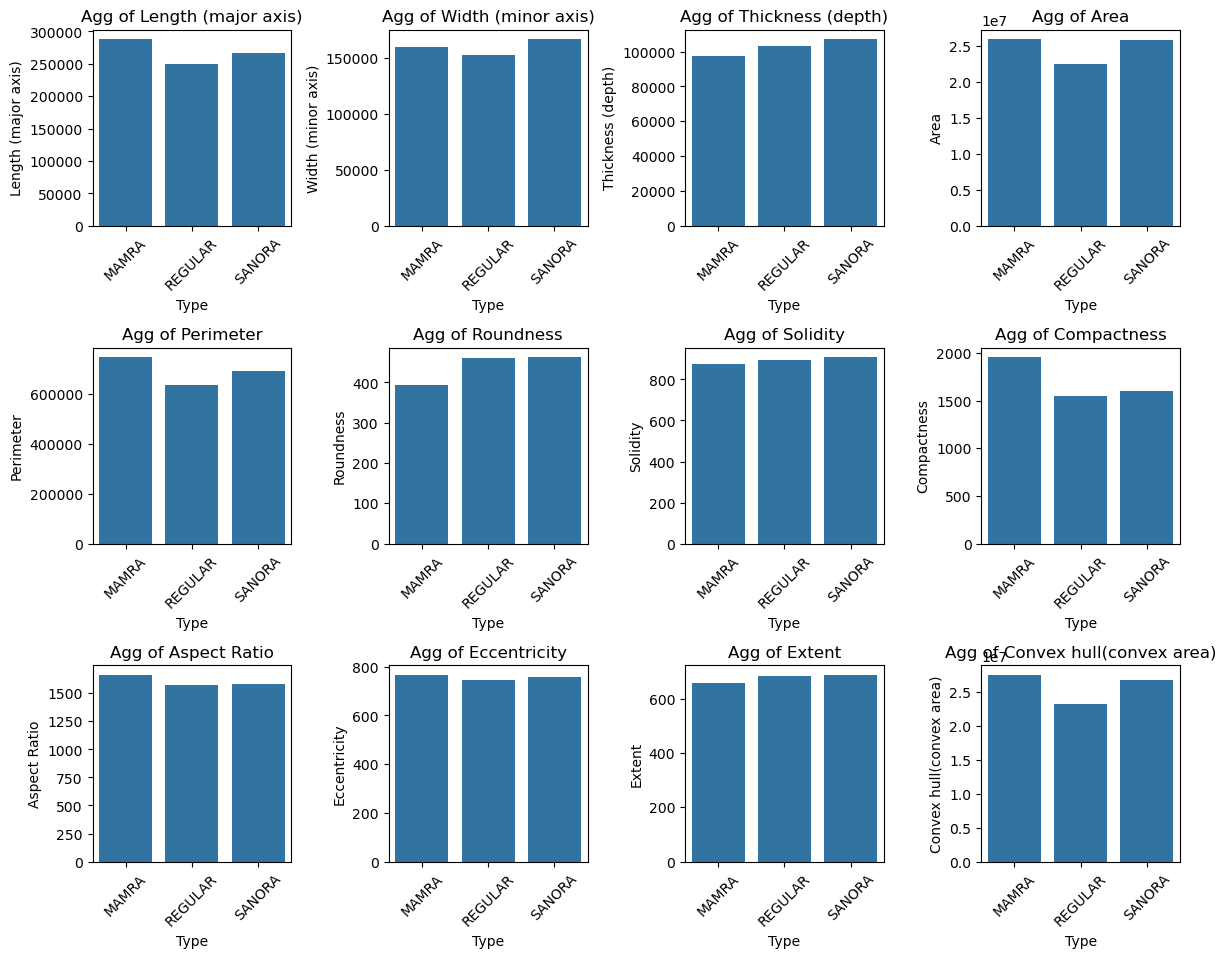

In [25]:
aggregate_dataset(process_df, process_df.columns, 'Type', "sum")

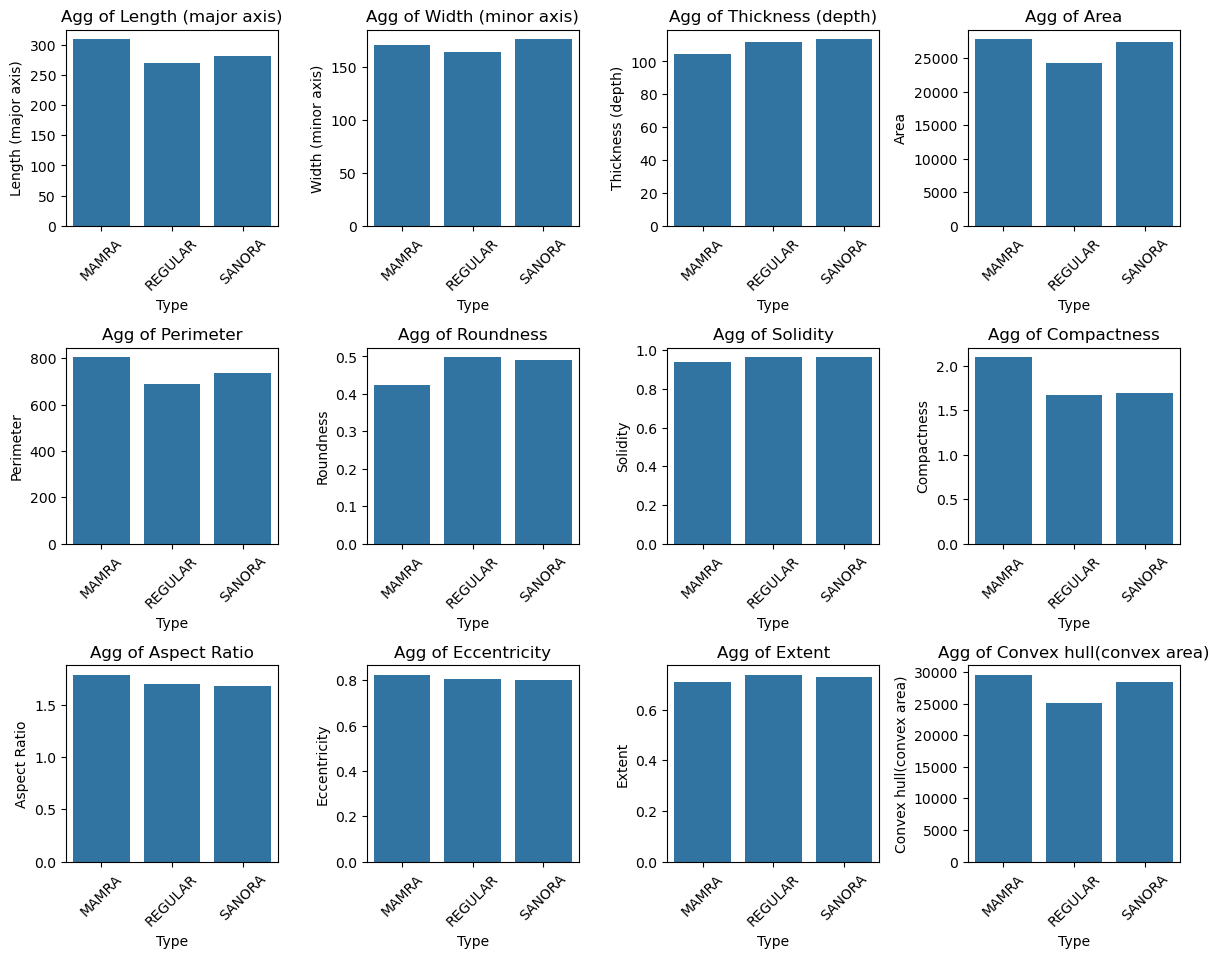

In [29]:
aggregate_dataset(process_df, process_df.columns, 'Type', "mean")

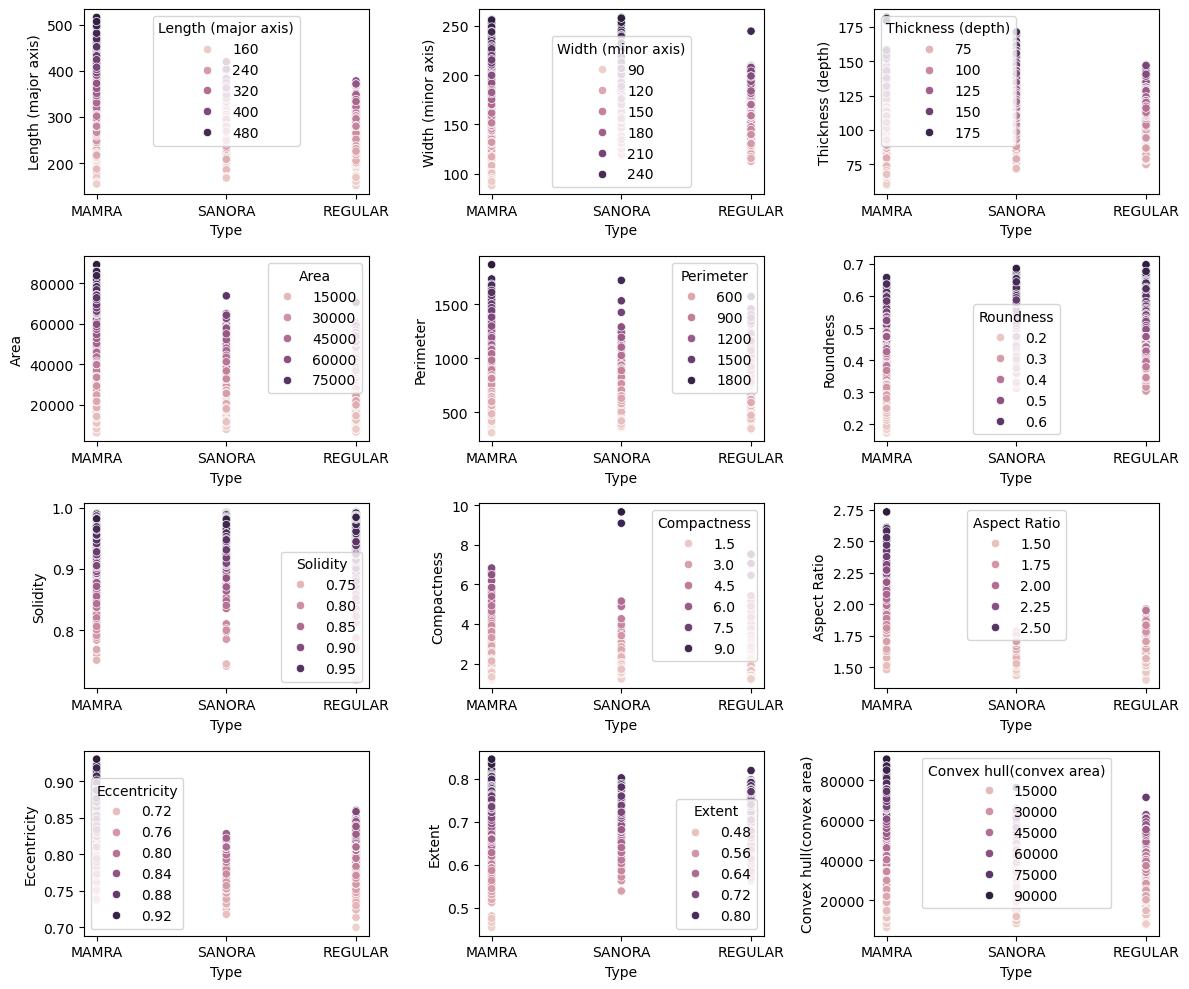

In [31]:
scatter_plot(process_df, process_df.columns, "Type")

# Chi Test

In [33]:
interested_columns = [col for col in process_df.columns if col != "Type"]

In [34]:
chi_value_tests(process_df, interested_columns, "Type")

Column Is: Length (major axis)
Chi-Square Test:
Chi2 Statistic: 3890.266134914012, P-value: 0.4867362650032415
Column Is: Width (minor axis)
Chi-Square Test:
Chi2 Statistic: 3716.3946872803194, P-value: 0.4950886386774174
Column Is: Thickness (depth)
Chi-Square Test:
Chi2 Statistic: 3594.236191211997, P-value: 0.4863417654044463
Column Is: Area
Chi-Square Test:
Chi2 Statistic: 5513.002278995796, P-value: 0.4406610632303874
Column Is: Perimeter
Chi-Square Test:
Chi2 Statistic: 5594.006994816872, P-value: 0.45979760906449063
Column Is: Roundness
Chi-Square Test:
Chi2 Statistic: 3890.2661349140117, P-value: 0.4867362650032436
Column Is: Solidity
Chi-Square Test:
Chi2 Statistic: 5600.0, P-value: 0.48994781881339866
Column Is: Compactness
Chi-Square Test:
Chi2 Statistic: 5599.999999999999, P-value: 0.4899478188134021
Column Is: Aspect Ratio
Chi-Square Test:
Chi2 Statistic: 2006.174989127831, P-value: 0.4821044524081613
Column Is: Eccentricity
Chi-Square Test:
Chi2 Statistic: 2006.1749891278

# Separate X, y values

In [42]:
X = df.drop("Type", axis=1)
y = df["Type"]

In [43]:
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Create Preprocessor

In [46]:
preprocessor = create_column_transformer(X.columns, mean_values, median_values)
preprocessor

ColumnTransformer(transformers=[('mean transformer',
                                 Pipeline(steps=[('mean', SimpleImputer())]),
                                 ['Width (minor axis)', 'Thickness (depth)',
                                  'Eccentricity']),
                                ('median transformer',
                                 Pipeline(steps=[('median',
                                                  SimpleImputer(strategy='median'))]),
                                 ['Length (major axis)', 'Roundness',
                                  'Aspect Ratio']),
                                ('numeric',
                                 Pipeline(steps=[('scaler', StandardScaler()),
                                                 ('PowerTransformer',
                                                  PowerTransformer())]),
                                 Index(['Length (major axis)', 'Width (minor axis)', 'Thickness (depth)',
       'Area', 'Perimeter', 'Roundness', 'Solidity', 'Compactness',
       'Aspect Ratio', 'Eccentricity', 'Extent', 'Convex hull(convex area)'],
      dtype='object'))])